Paths configured.
Loading CSVs...
2015 Data: 35126 images
2019 Data: 3662 images
2019 Split -> Train: 2929 | Val: 733

--- PIPELINE READY ---
1. Pre-training on: 35126 images (2015)
2. Fine-tuning on:  2929 images (2019)
3. Validating on:   733 images (2019)

Visualizing Enhanced Batch from 2019 Dataset...


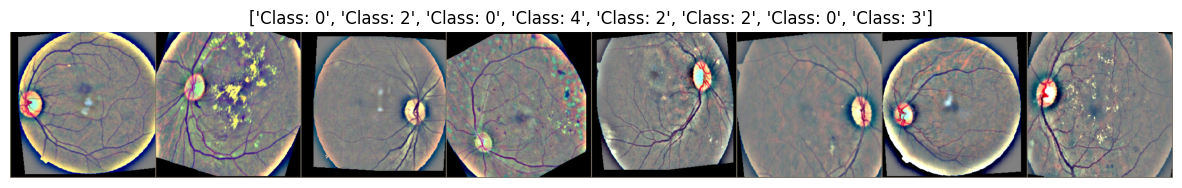

In [ ]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# --- 1. CONFIGURATION ---
BASE_PATH = "/kaggle/input/resized-2015-2019-blindness-detection-images"

# Image Directories
DIR_15 = os.path.join(BASE_PATH, "resized train 15")
DIR_19 = os.path.join(BASE_PATH, "resized train 19")

# Label Files (Corrected Paths)
CSV_15 = os.path.join(BASE_PATH, "labels", "trainLabels15.csv")
CSV_19 = os.path.join(BASE_PATH, "labels", "trainLabels19.csv")

IMG_SIZE = 300
BATCH_SIZE = 32
NUM_WORKERS = 2

print("Paths configured.")
aav
# --- 2. BEN GRAHAM PREPROCESSING ---
class BenGrahamPreprocessing:
    def __init__(self, sigmaX=10):
        self.sigmaX = sigmaX
    def __call__(self, img):
        img = np.array(img)
        # Formula: image = image * 4 - gaussian_blur * 4 + 128
        img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0), self.sigmaX), -4, 128)
        return Image.fromarray(img)

# Transforms
bg_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        BenGrahamPreprocessing(sigmaX=10),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=30),
        transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        BenGrahamPreprocessing(sigmaX=10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# --- 3. CUSTOM DATASET CLASS ---
class UnifiedDRDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Standardize columns: 'image_id', 'label'
        img_id = str(self.df.iloc[idx]['image_id'])
        label = int(self.df.iloc[idx]['label'])

        # Check .jpg, fallback to .png
        img_path = os.path.join(self.root_dir, img_id + ".jpg")
        if not os.path.exists(img_path):
             img_path = os.path.join(self.root_dir, img_id + ".png")

        try:
            image = Image.open(img_path)
        except Exception as e:
            print(f"Warning: Could not load {img_path}. Error: {e}")
            image = Image.new('RGB', (IMG_SIZE, IMG_SIZE), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

# --- 4. PREPARE DATAFRAMES ---
print("Loading CSVs...")
df_15 = pd.read_csv(CSV_15)
df_19 = pd.read_csv(CSV_19)

# Standardize Columns
df_15 = df_15.rename(columns={'image': 'image_id', 'level': 'label'})
df_19 = df_19.rename(columns={'id_code': 'image_id', 'diagnosis': 'label'})

# Clean Extensions
df_15['image_id'] = df_15['image_id'].astype(str).str.replace('.jpg', '', regex=False)
df_19['image_id'] = df_19['image_id'].astype(str).str.replace('.jpg', '', regex=False)

print(f"2015 Data: {len(df_15)} images")
print(f"2019 Data: {len(df_19)} images")

# --- 5. SPLIT 2019 DATA (80/20 Split) ---
# test_size=0.2 creates the 80% Train / 20% Validation split you requested
train_df_19, val_df_19 = train_test_split(
    df_19,
    test_size=0.2,
    stratify=df_19['label'],
    random_state=42
)

print(f"2019 Split -> Train: {len(train_df_19)} | Val: {len(val_df_19)}")

# --- 6. CREATE DATASETS & LOADERS ---
# A. Robustness (2015 - All Train)
ds_15 = UnifiedDRDataset(df_15, DIR_15, transform=bg_transforms['train'])
loader_15 = DataLoader(ds_15, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

# B. Precision (2019 Train - 80%)
ds_19_train = UnifiedDRDataset(train_df_19, DIR_19, transform=bg_transforms['train'])
loader_19_train = DataLoader(ds_19_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

# C. Validation (2019 Val - 20%)
ds_19_val = UnifiedDRDataset(val_df_19, DIR_19, transform=bg_transforms['val'])
loader_19_val = DataLoader(ds_19_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("\n--- PIPELINE READY ---")
print(f"1. Pre-training on: {len(ds_15)} images (2015)")
print(f"2. Fine-tuning on:  {len(ds_19_train)} images (2019)")
print(f"3. Validating on:   {len(ds_19_val)} images (2019)")

# --- 7. VISUALIZATION (Verify Ben Graham Preprocessing) ---
def imshow_bg(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # HWC
    # Undo normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.figure(figsize=(15, 5))
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Visualize a batch from the 2019 Training Set
print("\nVisualizing Enhanced Batch from 2019 Dataset...")
inputs, classes = next(iter(loader_19_train))
out = torchvision.utils.make_grid(inputs[:8])
imshow_bg(out, title=[f"Class: {x.item()}" for x in classes[:8]])

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
import time
import copy

# --- CONFIGURATION ---
# We train on 4 classes (Merged)
NUM_CLASSES = 4
NUM_EPOCHS_PHASE_1 = 5  # 5 Epochs on the massive 2015 dataset is usually enough
SAVE_PATH_PHASE1 = "efficientnet_b3_phase1_robustness.pth"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# --- 1. MODEL SETUP ---
print("Initializing EfficientNet-B3 for Phase 1...")
model = models.efficientnet_b3(weights='DEFAULT')

# Modify Head for 4 Classes
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, NUM_CLASSES)

model = model.to(device)

# --- 2. OPTIMIZER ---
# Standard LR for pre-training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# --- 3. HELPER: LABEL MAPPING FUNCTION ---
# Maps standard 5 classes to your 4 merged classes on the fly
def map_labels_to_4_classes(labels):
    # 0 -> 0 (No DR)
    # 1 -> 1 (Mild)  \__ MERGE
    # 2 -> 1 (Mod)   /
    # 3 -> 2 (Severe)
    # 4 -> 3 (Proliferative)

    # Clone to avoid overwriting issues
    new_labels = labels.clone()
    # Map 2 (Mod) to 1 (Mild)
    new_labels[labels == 2] = 1
    # Shift 3 (Severe) down to 2
    new_labels[labels == 3] = 2
    # Shift 4 (Prolif) down to 3
    new_labels[labels == 4] = 3
    return new_labels

# --- 4. TRAINING LOOP (PHASE 1) ---
print(f"Starting Phase 1: Robustness Training on 2015 Data ({len(loader_15.dataset)} images)...")

for epoch in range(NUM_EPOCHS_PHASE_1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the 2015 Loader
    loop = tqdm(loader_15, total=len(loader_15), leave=True)
    loop.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS_PHASE_1}]")

    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        # APPLY MERGE MAPPING
        labels = map_labels_to_4_classes(labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Metrics
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        acc = 100 * correct / total

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item(), acc=f"{acc:.2f}%")

    # Checkpoint after every epoch (because 2015 training takes a long time)
    torch.save(model.state_dict(), SAVE_PATH_PHASE1)
    print(f" -> Epoch {epoch+1} Model Saved! (Train Acc: {acc:.2f}%)")

print("Phase 1 Complete. Model is now Robust.")

Initializing EfficientNet-B3 for Phase 1...


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 186MB/s] 


Starting Phase 1: Robustness Training on 2015 Data (35126 images)...


Epoch [1/5]: 100%|██████████| 1098/1098 [12:57<00:00,  1.41it/s, acc=77.79%, loss=0.53] 


 -> Epoch 1 Model Saved! (Train Acc: 77.79%)


Epoch [2/5]: 100%|██████████| 1098/1098 [12:07<00:00,  1.51it/s, acc=81.79%, loss=0.265]


 -> Epoch 2 Model Saved! (Train Acc: 81.79%)


Epoch [3/5]: 100%|██████████| 1098/1098 [11:55<00:00,  1.54it/s, acc=83.10%, loss=0.428]


 -> Epoch 3 Model Saved! (Train Acc: 83.10%)


Epoch [4/5]: 100%|██████████| 1098/1098 [11:57<00:00,  1.53it/s, acc=84.10%, loss=0.681]


 -> Epoch 4 Model Saved! (Train Acc: 84.10%)


Epoch [5/5]: 100%|██████████| 1098/1098 [12:03<00:00,  1.52it/s, acc=84.78%, loss=0.245]

 -> Epoch 5 Model Saved! (Train Acc: 84.78%)
Phase 1 Complete. Model is now Robust.


In [ ]:
import torch
from tqdm import tqdm

# --- CONFIGURATION ---
MODEL_PATH = "efficientnet_b3_phase1_robustness.pth"
# Ensure we use the 2019 Validation Loader
val_loader = loader_19_val

# --- HELPER: LABEL MAPPING (5 -> 4 Classes) ---
def map_labels_to_4_classes(labels):
    # Maps standard 5 classes to your 4 merged classes
    # 0 -> 0, 1/2 -> 1, 3 -> 2, 4 -> 3
    new_labels = labels.clone()
    new_labels[labels == 2] = 1
    new_labels[labels == 3] = 2
    new_labels[labels == 4] = 3
    return new_labels

# --- EVALUATION LOOP ---
def check_accuracy(loader, model, device="cuda"):
    print("Checking Accuracy on 2019 Validation Data...")

    # Load the Phase 1 weights
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()
    model.to(device)

    correct = 0
    total = 0

    # Progress bar for evaluation
    loop = tqdm(loader, leave=True)

    with torch.no_grad():
        for images, labels in loop:
            images = images.to(device)
            labels = labels.to(device)

            # CRITICAL: Map targets to match the model's 4-class output
            labels = map_labels_to_4_classes(labels)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update bar with current average
            current_acc = 100 * correct / total
            loop.set_postfix(val_acc=f"{current_acc:.2f}%")

    final_acc = 100 * correct / total
    print(f"\n--- Phase 1 Validation Result ---")
    print(f"Accuracy on Clean 2019 Data: {final_acc:.2f}%")
    return final_acc

# Run the check
check_accuracy(val_loader, model)

Checking Accuracy on 2019 Validation Data...


100%|██████████| 23/23 [00:14<00:00,  1.58it/s, val_acc=80.35%]


--- Phase 1 Validation Result ---
Accuracy on Clean 2019 Data: 80.35%


80.35470668485675

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
import os

# --- 1. CONFIGURATION ---
NUM_CLASSES = 4
NUM_EPOCHS_PHASE_2 = 15
LEARNING_RATE = 1e-5  # Low LR for Fine-Tuning
LOAD_PATH = "efficientnet_b3_phase1_robustness.pth"
SAVE_PATH_FINAL = "efficientnet_b3_final_aptos.pth"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# --- 2. MODEL SETUP ---
print("Initializing Model for Phase 2 (Fine-Tuning)...")
model = models.efficientnet_b3(weights=None) # We load our own weights
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, NUM_CLASSES)

# Load Phase 1 Weights
if os.path.exists(LOAD_PATH):
    model.load_state_dict(torch.load(LOAD_PATH))
    print(f"Successfully loaded Robustness weights from: {LOAD_PATH}")
else:
    print(f"WARNING: {LOAD_PATH} not found. Starting from scratch (Not Recommended).")

model = model.to(device)

# --- 3. OPTIMIZER & SCHEDULER ---
criterion = nn.CrossEntropyLoss()
# Low LR (1e-5) + Weight Decay for regularization
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
# Scheduler to squeeze out final accuracy
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# --- 4. HELPER: LABEL MAPPING ---
def map_labels_to_4_classes(labels):
    # Maps 2019 labels (0-4) to Merged labels (0-3)
    new_labels = labels.clone()
    new_labels[labels == 2] = 1 # Map Mod to Mild
    new_labels[labels == 3] = 2 # Shift Severe
    new_labels[labels == 4] = 3 # Shift Proliferative
    return new_labels

# --- 5. TRAINING LOOP (PHASE 2) ---
print(f"Starting Phase 2: Fine-Tuning on 2019 Data ({len(loader_19_train.dataset)} images)...")
best_acc = 0.0

for epoch in range(NUM_EPOCHS_PHASE_2):
    # --- TRAINING ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    loop = tqdm(loader_19_train, leave=True)
    loop.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS_PHASE_2}]")

    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        # Map Labels
        labels = map_labels_to_4_classes(labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Metrics
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        train_acc = 100 * correct_train / total_train

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item(), train_acc=f"{train_acc:.2f}%")

    # --- VALIDATION ---
    model.eval()
    correct_val = 0
    total_val = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for images, labels in loader_19_val:
            images = images.to(device)
            labels = labels.to(device)

            # Map Labels
            labels = map_labels_to_4_classes(labels)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_acc = 100 * correct_val / total_val
    avg_val_loss = val_running_loss / total_val

    print(f" -> Validation Accuracy: {val_acc:.2f}% | Val Loss: {avg_val_loss:.4f}")

    # Update Scheduler
    scheduler.step(avg_val_loss)

    # Save Best Model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), SAVE_PATH_FINAL)
        print(f" -> Model Saved! (New Best: {best_acc:.2f}%)")

print("Training Complete! Final Model Ready.")

Initializing Model for Phase 2 (Fine-Tuning)...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Successfully loaded Robustness weights from: efficientnet_b3_phase1_robustness.pth
Starting Phase 2: Fine-Tuning on 2019 Data (2929 images)...


Epoch [1/15]: 100%|██████████| 92/92 [01:05<00:00,  1.41it/s, loss=0.528, train_acc=83.07%]


 -> Validation Accuracy: 86.77% | Val Loss: 0.4253
 -> Model Saved! (New Best: 86.77%)


Epoch [2/15]: 100%|██████████| 92/92 [00:59<00:00,  1.53it/s, loss=0.3, train_acc=87.03%]  


 -> Validation Accuracy: 87.99% | Val Loss: 0.3647
 -> Model Saved! (New Best: 87.99%)


Epoch [3/15]: 100%|██████████| 92/92 [00:59<00:00,  1.55it/s, loss=0.207, train_acc=88.22%]


 -> Validation Accuracy: 88.81% | Val Loss: 0.3465
 -> Model Saved! (New Best: 88.81%)


Epoch [4/15]: 100%|██████████| 92/92 [01:00<00:00,  1.53it/s, loss=0.621, train_acc=88.08%]


 -> Validation Accuracy: 89.22% | Val Loss: 0.3282
 -> Model Saved! (New Best: 89.22%)


Epoch [5/15]: 100%|██████████| 92/92 [00:59<00:00,  1.53it/s, loss=0.452, train_acc=88.46%]


 -> Validation Accuracy: 89.36% | Val Loss: 0.3188
 -> Model Saved! (New Best: 89.36%)


Epoch [6/15]: 100%|██████████| 92/92 [00:59<00:00,  1.55it/s, loss=0.274, train_acc=89.69%]


 -> Validation Accuracy: 89.36% | Val Loss: 0.3126


Epoch [7/15]: 100%|██████████| 92/92 [01:00<00:00,  1.53it/s, loss=0.524, train_acc=89.11%]


 -> Validation Accuracy: 90.18% | Val Loss: 0.3043
 -> Model Saved! (New Best: 90.18%)


Epoch [8/15]: 100%|██████████| 92/92 [00:59<00:00,  1.54it/s, loss=0.218, train_acc=89.69%]


 -> Validation Accuracy: 89.90% | Val Loss: 0.3045


Epoch [9/15]: 100%|██████████| 92/92 [01:00<00:00,  1.52it/s, loss=0.222, train_acc=89.59%] 


 -> Validation Accuracy: 90.04% | Val Loss: 0.3019


Epoch [10/15]: 100%|██████████| 92/92 [00:59<00:00,  1.54it/s, loss=0.167, train_acc=90.20%] 


 -> Validation Accuracy: 90.45% | Val Loss: 0.2906
 -> Model Saved! (New Best: 90.45%)


Epoch [11/15]: 100%|██████████| 92/92 [00:59<00:00,  1.53it/s, loss=0.372, train_acc=90.24%] 


 -> Validation Accuracy: 90.18% | Val Loss: 0.2942


Epoch [12/15]: 100%|██████████| 92/92 [00:59<00:00,  1.54it/s, loss=0.164, train_acc=90.10%] 


 -> Validation Accuracy: 90.18% | Val Loss: 0.2924


Epoch [13/15]: 100%|██████████| 92/92 [00:59<00:00,  1.54it/s, loss=0.142, train_acc=90.17%] 


 -> Validation Accuracy: 90.45% | Val Loss: 0.2912


Epoch [14/15]: 100%|██████████| 92/92 [00:59<00:00,  1.53it/s, loss=0.137, train_acc=90.51%] 


 -> Validation Accuracy: 90.86% | Val Loss: 0.2884
 -> Model Saved! (New Best: 90.86%)


Epoch [15/15]: 100%|██████████| 92/92 [01:00<00:00,  1.53it/s, loss=0.282, train_acc=90.34%] 


 -> Validation Accuracy: 90.72% | Val Loss: 0.2886
Training Complete! Final Model Ready.


In [ ]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninst

In [ ]:
# --- 6. GRAD-CAM VISUALIZATION BLOCK ---

# 1. Install Captum (Explainability Library)
try:
    import captum
except ImportError:
    !pip install captum -q
    import captum

from captum.attr import LayerGradCam
import torch.nn.functional as F
import matplotlib.pyplot as plt

# --- A. Helper to Undo Normalization for Plotting ---
def unnormalize_image(tensor_img):
    """
    Reverses the ImageNet normalization so we can see the image clearly.
    (Note: The Ben Graham preprocessing will still be visible)
    """
    # Mean and Std from your val_transform
    mean = torch.tensor([0.485, 0.456, 0.406]).to(DEVICE)
    std = torch.tensor([0.229, 0.224, 0.225]).to(DEVICE)

    img = tensor_img.clone().to(DEVICE)
    img = img * std[:, None, None] + mean[:, None, None]
    img = img.cpu().numpy()
    img = np.transpose(img, (1, 2, 0)) # Change (C,H,W) to (H,W,C)
    img = np.clip(img, 0, 1) # Ensure values are valid colors
    return img

# --- B. The Visualization Function ---
def run_grad_cam_analysis(model, data_loader, num_images=4):
    model.eval()

    # Target the last convolutional layer of EfficientNet-B3
    # This layer contains the most complex spatial features
    target_layer = model.features[-1]
    cam_extractor = LayerGradCam(model, target_layer)

    print(f"Generating Grad-CAM Heatmaps for {num_images} images...")

    # Get a single batch
    try:
        images, labels_orig = next(iter(data_loader))
        images = images.to(DEVICE)
        # Apply your mapping function (0-4 -> 0-3)
        labels = map_labels_to_4_classes(labels_orig.to(DEVICE))
    except Exception as e:
        print(f"Error loading batch: {e}")
        return

    # Class names corresponding to your 0-3 mapping
    class_names = ['No DR', 'Mild/Mod', 'Severe', 'Proliferative']

    # Setup Plot
    fig, axs = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))
    if num_images == 1: axs = axs[None, :]

    for i in range(num_images):
        # 1. Prediction
        input_tensor = images[i].unsqueeze(0) # Add batch dimension
        output = model(input_tensor)
        pred_prob = F.softmax(output, dim=1)
        pred_idx = torch.argmax(pred_prob).item()
        pred_name = class_names[pred_idx]

        true_idx = labels[i].item()
        true_name = class_names[true_idx]

        # 2. Generate Heatmap (Attribution)
        # We ask: "What part of the image made you predict [pred_idx]?"
        attribution = cam_extractor.attribute(input_tensor, target=pred_idx)

        # 3. Process Heatmap
        heatmap = attribution.squeeze().cpu().detach().numpy()
        heatmap = np.maximum(heatmap, 0) # ReLU: Keep only positive influence
        heatmap = heatmap / (np.max(heatmap) + 1e-10) # Normalize 0-1

        # Resize to image size
        orig_img = unnormalize_image(images[i])
        heatmap_resized = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))

        # Colorize (Blue=Low, Red=High importance)
        heatmap_uint8 = np.uint8(255 * heatmap_resized)
        heatmap_colored = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) / 255.0

        # Overlay
        overlay = (0.6 * orig_img) + (0.4 * heatmap_colored)
        overlay = np.clip(overlay, 0, 1)

        # 4. Plotting
        # Column 1: Original
        axs[i, 0].imshow(orig_img)
        axs[i, 0].set_title(f"Original (Ben Graham)\nTrue: {true_name}")
        axs[i, 0].axis('off')

        # Column 2: Heatmap
        axs[i, 1].imshow(heatmap_colored)
        axs[i, 1].set_title(f"Grad-CAM Heatmap\nFocus Areas")
        axs[i, 1].axis('off')

        # Column 3: Overlay
        axs[i, 2].imshow(overlay)
        axs[i, 2].set_title(f"Prediction: {pred_name}\n(Where the model looked)")
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# --- C. EXECUTION ---
# 1. Load Data (Shuffle=True to see different images each run)
# We use YOUR existing RetinopathyDatasetStrict and val_transform
cam_dataset = RetinopathyDatasetStrict(VAL_CSV_PATH, VAL_IMG_DIR, transform=val_transform)
cam_loader = DataLoader(cam_dataset, batch_size=4, shuffle=True, num_workers=2)

# 2. Load Model
cam_model = load_model(MODEL_PATH)

if cam_model:
    # 3. Run
    run_grad_cam_analysis(cam_model, cam_loader, num_images=4)
else:
    print("Model failed to load. Check MODEL_PATH.")

ModuleNotFoundError: No module named 'captum'

Setting up 2015 Test Loader...
2015 Test Set: 53576 images
Model Loaded.

--- Evaluating on APTOS 2019 Validation Set (High Quality) ---


Evaluating: 100%|██████████| 23/23 [00:12<00:00,  1.85it/s]



Accuracy:  90.86%
Precision: 0.9041
Recall:    0.9086

Detailed Classification Report:
               precision    recall  f1-score   support

        No DR     0.9944    0.9834    0.9889       361
     Mild/Mod     0.8333    0.9854    0.9030       274
       Severe     0.6923    0.2308    0.3462        39
Proliferative     0.8205    0.5424    0.6531        59

     accuracy                         0.9086       733
    macro avg     0.8351    0.6855    0.7228       733
 weighted avg     0.9041    0.9086    0.8955       733



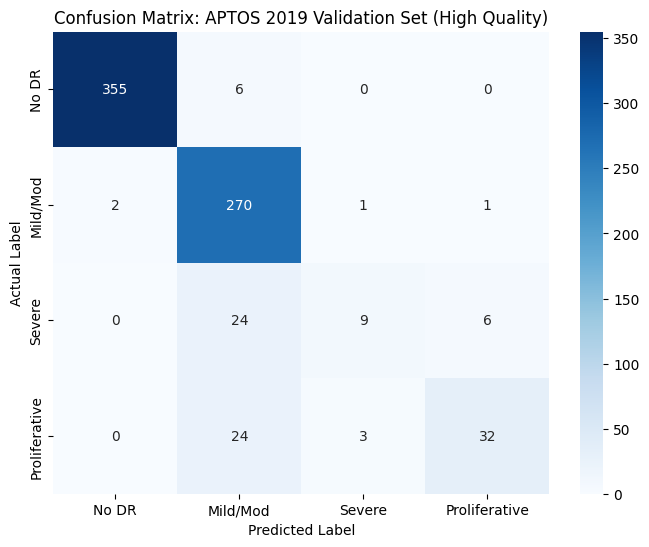


--- Evaluating on EyePACS 2015 Test Set (Robustness) ---


Evaluating: 100%|██████████| 1675/1675 [17:55<00:00,  1.56it/s]



Accuracy:  82.85%
Precision: 0.8088
Recall:    0.8285

Detailed Classification Report:
               precision    recall  f1-score   support

        No DR     0.8543    0.9788    0.9123     39533
     Mild/Mod     0.6852    0.4415    0.5370     11623
       Severe     0.5976    0.0404    0.0756      1214
Proliferative     0.7239    0.4262    0.5365      1206

     accuracy                         0.8285     53576
    macro avg     0.7152    0.4717    0.5154     53576
 weighted avg     0.8088    0.8285    0.8035     53576



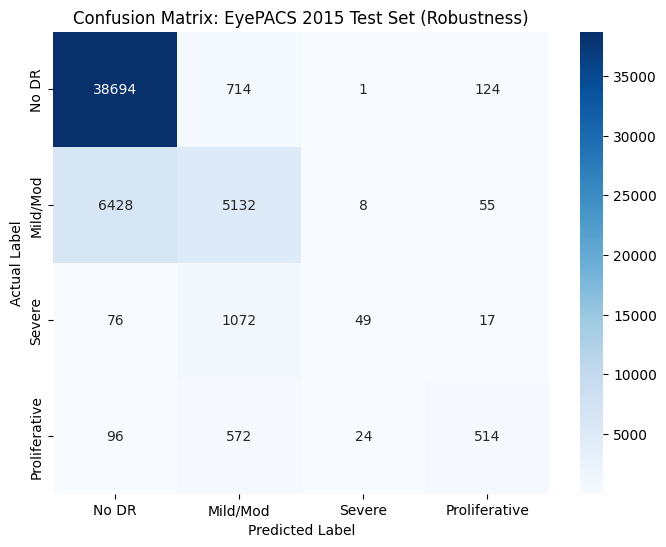

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
from tqdm import tqdm
import os

# --- 1. CONFIGURATION ---
MODEL_PATH = "efficientnet_b3_final_aptos.pth" # Phase 2 Polished Model
CSV_TEST_15 = os.path.join(BASE_PATH, "labels", "testLabels15.csv")
DIR_TEST_15 = os.path.join(BASE_PATH, "resized test 15")
NUM_CLASSES = 4
CLASS_NAMES = ['No DR', 'Mild/Mod', 'Severe', 'Proliferative']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# --- 2. LOAD 2015 TEST DATA (True Unseen Data) ---
print("Setting up 2015 Test Loader...")
df_test_15 = pd.read_csv(CSV_TEST_15)
df_test_15 = df_test_15.rename(columns={'image': 'image_id', 'level': 'label'})
df_test_15['image_id'] = df_test_15['image_id'].astype(str).str.replace('.jpg', '', regex=False)

# Re-use your UnifiedDRDataset class
ds_test_15 = UnifiedDRDataset(df_test_15, DIR_TEST_15, transform=bg_transforms['val'])
loader_test_15 = DataLoader(ds_test_15, batch_size=32, shuffle=False, num_workers=2)
print(f"2015 Test Set: {len(ds_test_15)} images")

# --- 3. HELPER: LABEL MAPPING (Same as training) ---
def map_labels(labels):
    # Maps 5 classes (0-4) to your 4 classes (0-3)
    new_labels = labels.clone()
    new_labels[labels == 2] = 1 # Map Mod to Mild
    new_labels[labels == 3] = 2 # Shift Severe
    new_labels[labels == 4] = 3 # Shift Proliferative
    return new_labels

# --- 4. EVALUATION FUNCTION ---
def evaluate_model(model, loader, dataset_name="Test Set"):
    print(f"\n--- Evaluating on {dataset_name} ---")
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)

            # Map Targets to 4 Classes
            labels = map_labels(labels)

            # Prediction
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # --- METRICS ---
    acc = accuracy_score(y_true, y_pred)
    # We use 'weighted' average for multi-class precision/recall
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"\nAccuracy:  {acc:.2%}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")

    # --- CLASSIFICATION REPORT ---
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

    # --- CONFUSION MATRIX ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title(f'Confusion Matrix: {dataset_name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# --- 5. EXECUTE ---
# Load Model
model = models.efficientnet_b3(weights=None)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.to(device)
    print("Model Loaded.")
else:
    print("Model weights not found!")

# Run on 2019 Validation (High Quality Proxy)
evaluate_model(model, loader_19_val, dataset_name="APTOS 2019 Validation Set (High Quality)")

# Run on 2015 Test (Massive Robustness Check)
# Note: 2015 Test is huge (53k images), this might take 10-15 mins.
evaluate_model(model, loader_test_15, dataset_name="EyePACS 2015 Test Set (Robustness)")

In [ ]:
from IPython.display import FileLink

# Replace 'my_model.pth' with your actual filename
FileLink(r'efficientnet_b3_final_aptos.pth')

/kaggle/working/efficientnet_b3_final_aptos.pth